#**Analisi e Classificazione delle Email per la Rilevazione di SPAM**

Lo scopo di questo progetto realizzato da me, Alessio Feudo, è sviluppare una serie di tools per l'analisi e la classificazione delle mail ricevute, ritracciando mail spam.
Il dataset fornito contiene mail spam e non, con lieve sbilanciamento in favore delle mail non spam.
Il progetto è diviso sulle seguenti fasi:
###Sviluppo algoritmo di classificazione
Per prima cosa, si vuole sviluppare un modello di classificazione in grado di riconoscere mail spam e non. Le soluzioni proposte sono di due tipi: la prima basata su codifica Tf-idf e **Multinomial Naive Bayes**, la seconda consistente in un modello **LLM** leggero preaddestrato, **TinyBert**, di cui è fatto il **Fine tuning**: infatti il numero di dati disponibili non permette l'addestramento da zero di reti neurali davvero efficaci, per cui si sceglie la strada del fine tuning. Innazitutto, si attua la pulizia del dato testuale (lowercasing, lemmatization, punteggiatura, fattori numerici, spazi) per poi procedere alla codifica e all'addestramento dei modelli.

###Individuare topic principali nelle mail spam

Come seconda analisi, si vogliono individuare i topics principali presenti nelle mail spam, per una loro caratterizzazione. Per fare ciò, si applica l'algoritmo Latent Dirichlet Allocation (**LDA**) e si visualizzano ed etichettano i topics estratti.

###Calcolo della distanza semantica tra i topics

Una volta estratti i topics, si calcola la **distanza semantica** che intercorre tra essi, per valutare la loro eterogeneità, facendo uso della **'cosine similarity'**.

###NER su mail non spam
Infine, si applica la Name Entity Recognition (**NER**) sulle mail non spam, per individuare organizzazioni/enti citati.

In [ ]:
pip install nlpaug


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.9 MB/s eta 0:00:00


In [ ]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 47.8 MB/s eta 0:00:00


In [ ]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.7 MB/s eta 0:00:00


In [ ]:
pip install transformers

In [ ]:
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, log_loss, accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support
from scipy.stats import uniform
import nlpaug.augmenter.word as naw
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from IPython.display import display
import nltk
nltk.download('averaged_perceptron_tagger_eng') # pretrained POS tagger model
warnings.filterwarnings('ignore', category=DeprecationWarning)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
#stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###**Caricamento e analisi preliminare sul dataset**

In [ ]:
# dataset loading
df=pd.read_csv('https://raw.githubusercontent.com/ProfAI/natural-language-processing/refs/heads/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv')

In [ ]:
# dataset visualization
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [ ]:
# dataset insights: n of samples per label
print(f"N. spam mails: {np.sum(df['label_num']==1)}")
print(f"N. NON spam mails: {np.sum(df['label_num']==0)}")

#average number of words per document
print('Average number of words per sample: ', int(df['text'].apply(lambda x: len(x.split())).mean()))

N. spam mails: 1499
N. NON spam mails: 3672
Average number of words per sample:  227


In [ ]:
# Nan check
df.isna().sum()

,0
Unnamed: 0,0
label,0
text,0
label_num,0


In [ ]:
#cleaning dictionary
english_stopwords=stopwords.words('english') #english stopwords
nlp=spacy.load('en_core_web_sm') # loading pretrained english language model
punctuation=set(string.punctuation) # punctuation set

# dictionary to store stowords, language model and punctuation set
utils_dict={'stopwords':english_stopwords,
            'nlp':nlp,
            'punctuation':punctuation}

#**Cleaning del dataset**
Per prima cosa si applica la pulizia del dataset, in modo da ottenere frasi prive di caratteri poco informativi, così da ridurre la complessità del vocabolario che sarà successivamente creato.

In [ ]:
def data_cleaning(sentence, utils_dict):
    '''
    Function to clean text from stopwords, punctuation, multiple spaces, numbers, applying lowercasing and lemmatization.
    Args:
        - sentence (str): text to process
        - utils_dict (dict): dictionary to store:
                - 'stopwords' (list): set of stopwords to remove.
                - 'punctuation' (set): punctuation to be removed.
                - 'nlp' (callable): language model used for lemmatization.
    Returns:
        - (str): processed input sentence
    '''
    # lowercase
    sentence=sentence.lower()
    # punctuation substutition with a single space
    for c in utils_dict['punctuation']:
        sentence=sentence.replace(c," ")
    # lemmatization
    document=utils_dict['nlp'](sentence)
    sentence=" ".join(token.lemma_ for token in document)

    # stopwords remotion
    sentence=" ".join(word for word in sentence.split() if word not in utils_dict['stopwords'])
    # numbers substitution with a single space
    sentence=re.sub('\d', ' ', sentence)
    # multiple spaces substitution with only one
    sentence=re.sub(' +', ' ', sentence)
    return sentence

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-781934167.py:25: SyntaxWarning: invalid escape sequence '\d'
  sentence=re.sub('\d', ' ', sentence)


In [ ]:
# cleaning dataset with cleaning function
text_cleaned=[data_cleaning(sentence, utils_dict) for sentence in df['text']]

# defining the cleaned dataframe
df_cleaned=pd.DataFrame({'text': text_cleaned,
                         'label_num': df['label_num'].values})

df_cleaned.head()

,text,label_num
0,subject enron methanol meter follow note I giv...,0
1,subject hpl nom january see attach file hplnol...,0
2,subject neon retreat ho ho ho around wonderful...,0
3,subject photoshop window office cheap main tre...,1
4,subject indian spring deal book teco pvr reven...,0


In [ ]:
# checking cleaning procedure
print(f"Original sentence:\n{df['text'][0]}\n")
print(f"Processed sentence:\n{df_cleaned['text'][0]}")

Original sentence:
Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .

Processed sentence:
subject enron methanol meter follow note I give monday preliminary flow datum provide daren please override pop daily volume presently zero reflect daily activity obtain gas control change need asap economic purpose


#**Divisione dataset**
Secondo passaggio fondamentale è la divisione del dataset inziale in set di training e test. Il set di validazione non è creato in quanto gli algoritmi sviluppati implementeranno in automatico la validazione dividendo internamente il set di training, oppure nel caso di TinyBert, non sarà eseguita validazione.

In [ ]:
# x, y definition
x=df_cleaned['text']
y=df_cleaned['label_num'].to_numpy()

In [ ]:
# train/test split
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)


#**Data augmentation**
Come menzionato, il dataset è risultato essere sbilanciato in favore delle mail non spam. Per questo, sul set di training viene applicata data augmentation per bilanciarlo. La data augmentation è attuata usando sostituzione con sinonimi tramite la libreria nlpaug: si seleziona in modo random un sample di mail spam e si applica sostituzione con sinonimi creando una copia variata del sample originale.

In [ ]:
def relative_abundance_labels(y_train, verbose=False):
    '''
    Function to analyze the abundance of spam and non_spam mails.
    In the verbose mode, it only prints some abundance insights, while in the non verbose one it returns the number of spam mails found.
    Args:
        - y_train (np.ndarray): training set labels
        - verbose (bool): if True, it prints insights. If False, it returns the spam count. Default is False.

    Returns:
        - (int): number of spam mails found in y_train
    '''
    n_spam=np.sum(y_train) # number of spam mails
    ratio=n_spam/(len(y_train)-n_spam) # spam/non_spam ratio

    if verbose==True: # verbose mode (only for insights)
        print(f"Spam samples: {n_spam}, Len y_train: {len(y_train)}")
        print(f"ratio spam/no_spam: {ratio:.2f}")
    else: # non verbose mode (only for operations)
        return n_spam


def data_augmentation(x_train, y_train):
    '''
    Function to perform data augmentation, randomly selecting the sample to augment with synonyms,
    until the number of needed new samples is reached.
    Args:
        - x_train (pd.Series): training set text
        - y_train (np.ndarray): training set labels

    Returns:
        - (pd.Series): x_train after augmentation
        - (np.ndarray): y_train after augmentation
    '''
    #number of needed spam samples to balance the dataset
    n_spam=relative_abundance_labels(y_train)
    n_of_new_samples=(len(y_train)-n_spam)-n_spam  # n_nonspam-n_spam_actual

    #augmenter
    aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)
    # spam, no_spam filtering
    x_spam = x_train[y_train == 1]
    x_nospam = x_train[y_train == 0]
    x_spam_augmented=[]

    # given the number of needed samples to generate, each of them is generated augmenting a random real spam sample
    for _ in range(n_of_new_samples):
        x = x_spam.sample(n=1).iloc[0] # randomly extracting a sample from x_spam
        augmented = aug.augment(x)
        x_spam_augmented.append(augmented[0] if isinstance(augmented, list) else augmented)

    x_train_balanced = list(x_spam)+x_spam_augmented + list(x_nospam)
    y_train_balanced = [1] * (len(x_spam_augmented)+len((x_spam))) + [0] * len(x_nospam)

    return pd.Series(x_train_balanced), np.array(y_train_balanced)


In [ ]:
# augmentation application
relative_abundance_labels(y_train, verbose=True)
x_train_aug, y_train_aug=data_augmentation(x_train, np.array(y_train))
relative_abundance_labels(y_train_aug, verbose=True)

Spam samples: 1206, Len y_train: 4136
ratio spam/no_spam: 0.41
Spam samples: 2930, Len y_train: 5860
ratio spam/no_spam: 1.00


#**Modello Naive Bayes**
Per classificare le mail spam e non spam, si inizia implementando un modello Naive Bayes multinomiale: questo modello è infatti uno degli approcci più semplici e inerenti al task. Il dataset testuale precedentemente pulito, viene ora codificato utilizzando Tf-idf: anche se il Multinomial NB nasce per operare su conteggi discreti, usare Tf-idf che pesa le parole considerando l'intero corpus di documenti può essere una buona scelta per discriminare di più parole comuni.

Per selezionare il miglior valore dell'iperparametro alpha del modello (utile alla stabilità numerica del modello stesso e alla generalizzazione) si sfrutta una random search, considerando una distribuzione uniforme per i valori del parametro stesso, tra 0 e 1.
Infine il modello è valutato tramite diverse metriche e grafici come la matrice di confusione, la ROC e la learning curve.


In [ ]:
def tfidf_NB(x_train, x_test):
    '''
    Function to vectorize text using Tf-Idf.
    Args:
        - x_train (pd.Series): training text
        - x_test (pd.Series): test text
    Returns:
        - (np.ndarray): vectorized x_train
        - (np.ndarray): vectorized x_test
    '''
    tfidf=TfidfVectorizer() # tfidf vectorizer initialization
    # trasforming x_train and x_test
    x_train_vec=tfidf.fit_transform(x_train)
    x_test_vec=tfidf.transform(x_test)
    # numpy dense representation
    x_train_vec = x_train_vec.toarray()
    x_test_vec = x_test_vec.toarray()

    print(f"Vocabulary len: {len(tfidf.vocabulary_)}") # vocabulary length
    return x_train_vec, x_test_vec

In [ ]:
def naiveBayes(x_train_vec, y_train):
    '''
    The function trains a multinomial naive bayes model, optimizing hyperparameters using random search.
    Args:
        - x_train_vec (np.ndarray): train vectorized text
        - y_train (np.ndarray): train labels
    Returns:
        - (sklearn.MultinomialNB): the best model extracted from random search
    '''
    # naive bayes initialization
    model=MultinomialNB()

    # parameters dict: parameter dstribution for random search
    param_dict = {'alpha': uniform(0, 1)}

    # Random search using 3 folds and 5 iterations
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dict,
        n_iter=5,
        cv=3,
        scoring='f1', # model evaluation based on f1 score
        random_state=42,
        n_jobs=-1)

    # random search fit
    random_search.fit(x_train_vec, y_train)

    print(f"Best alpha: {random_search.best_params_['alpha']:.2f}")
    print(f"Best score: {random_search.best_score_:.2f}")

    # best model extraction based on max f1
    best_model = random_search.best_estimator_
    return best_model

In [ ]:
def confusion(y_true, y_pred, name):
  '''
   This function shows the confusion matrix of the model.
   Args:
       - y_true (np.array): true target
       - y_pred (np.array): predicted target
       - name (str): string to insert in the plot title
  '''
  cm=confusion_matrix(y_true, y_pred)
  #confusion matrix as dataframe
  df_cm=pd.DataFrame(cm, index=['True Negative','True Positive'], columns=['Predicted Negative','Predicted Positive'])
  # confusion matrix heatmap
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title(f"CONFUSION MATRIX-{name}")
  plt.show()


def evaluate_model(x_train, y_train, x_test, y_test, model, thresh=0.50):
  '''
  The function evaluates the input model through many classification metrics.
  Args:
      - x_train (np.array): train samples
      - y_train (np.array): train true target
      - x_test (np.array): test smaples
      - y_test (np.array): test true target
      - model (obj): model to evaluate
      - thresh (float): classification threshold. Default: 0.50
  '''
  # Predicted proba on trainig and test sets
  y_prob_train=model.predict_proba(x_train)
  y_prob_test=model.predict_proba(x_test)

  # model predictions on training and test sets
  y_pred_train=np.where(y_prob_train[:,1]>thresh,1,0)
  y_pred_test=np.where(y_prob_test[:,1]>thresh,1,0)

  #log loss train and test
  print(f"Log_loss_train: {round(log_loss(y_train, y_prob_train),3)}\nLog_loss_test: {round(log_loss(y_test, y_prob_test),3)}\n")
  #classification report train and test
  print(f"CLASSIFICATION REPORT TRAIN\n{classification_report(y_train, y_pred_train)}")
  print(f"CLASSIFICATION REPORT TEST\n{classification_report(y_test, y_pred_test)}")

  #plot confusion matrix train and test
  confusion(y_train, y_pred_train, 'TRAIN')
  confusion(y_test, y_pred_test, 'TEST')

  #plot Roc and AUC train and test
  fig, ax = plt.subplots() #same figure for train and test, passing the same axis, ax.
  roc_train=RocCurveDisplay.from_estimator(model, x_train, y_train, ax=ax, name='ROC Training')
  roc_test=RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax, name='ROC Test')
  plt.show()

  # Learning curve
  # StratifiedKFold to build folds used by cross validation, such as in each fold the target distribution is the same as in the whole dataset.
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
  train_sizes = np.linspace(0.1, 1.0, 10) #learning curve will fit the model on 5 data subsets.
  train_size_abs, train_scores, test_scores=learning_curve(model,
                                                           x_train,
                                                           y_train,
                                                           cv=cv,
                                                           train_sizes=train_sizes,
                                                           n_jobs=-1,
                                                           scoring='recall', # lerning curve will rely on recall
                                                           error_score='raise',
                                                           )

  plt.xlabel('Sample')
  plt.ylabel('Recall')
  plt.plot(train_size_abs, train_scores.mean(axis=1), label='Learning curve training')
  plt.plot(train_size_abs, test_scores.mean(axis=1), label='Learning curve test')
  plt.legend()
  plt.show()


In [ ]:
# tfidf
x_train_vec, x_test_vec=tfidf_NB(x_train_aug, x_test)

# NB_model
NB_model=naiveBayes(x_train_vec, y_train_aug)

Vocabulary len: 38727
Best alpha: 0.16
Best score: 0.98


Log_loss_train: 0.02
Log_loss_test: 0.058

CLASSIFICATION REPORT TRAIN
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2930
           1       0.99      0.99      0.99      2930

    accuracy                           0.99      5860
   macro avg       0.99      0.99      0.99      5860
weighted avg       0.99      0.99      0.99      5860

CLASSIFICATION REPORT TEST
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       742
           1       0.95      0.97      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.97      1035
weighted avg       0.98      0.98      0.98      1035



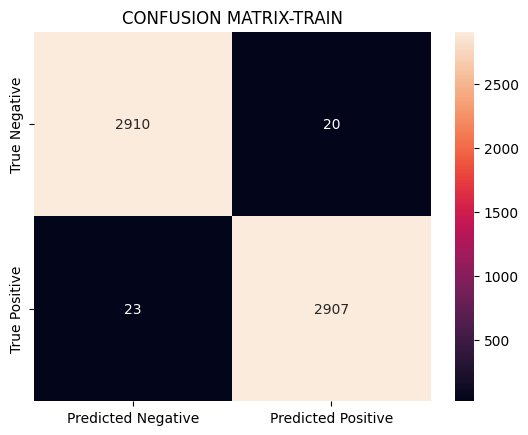

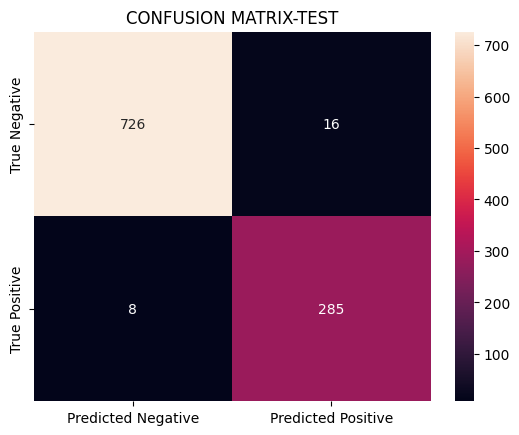

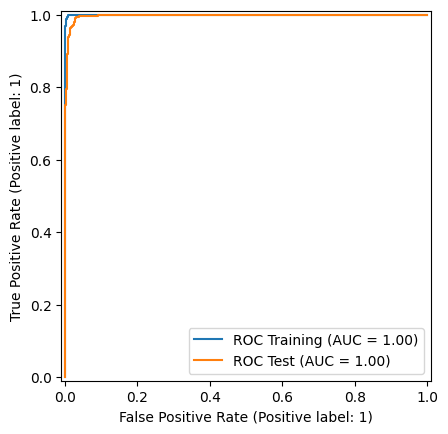

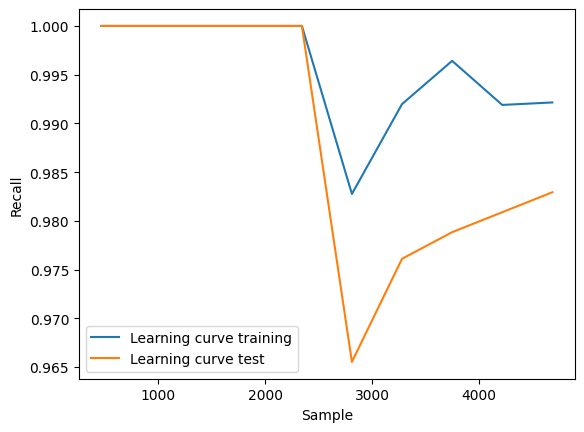

In [ ]:
#NB evaluation
evaluate_model(x_train_vec, y_train_aug, x_test_vec, np.array(y_test), NB_model)

Si nota come il semplice modello NB, porti a performance eccellenti. Nella learning curve si osserva come il modello abbia prestazioni elevate, con poca differenza tra training e test, mentre dalla matrice di confusione si evidenzia come il modello tenda a sbagliare molto poco.

#**Tiny Bert**
Per confronto, si adatta anche un modello Transformer preaddestrato di piccole dimensioni, TinyBert, basato su un'architettura Encoder-only, facendone il fine tuning sui dati di mail a disposizione nel progetto. Il modello è implementato utilizzando Pytorch e reca con se il suo tokenizer specifico: i dati testuali sono quindi processati dopo il cleaning direttamente dal tokenizer di Bert.
Il training è implementato in versione semplificata, settando 3 epoche, non usando set di validazione e non attivando tools come early stopping per semplicità. Al termine dell'addestramento si valuta il modello.

In [ ]:
def tokenize_function(samples):
    '''
    The function applies TinyBert text tokenization.
    Args:
        - samples (dict): dictionary storing list of text samples
    Returns:
        - (dict): tokenized input data
    '''
    return tokenizer(samples["text"], padding="max_length", truncation=True, max_length=128)


def compute_metrics(eval_pred):
    '''
    The function computes several metrics for TinyBert model used for classification task.
    Args:
        - eval_pred (tuple): tuple (logits, labels)
    Returns:
        - (dict): dictionary storing (metric_name: value)
    '''
    # extracting logits (model prediction scores for each label) and labels (true labels)
    logits, labels = eval_pred
    # model predictions, selecting the highest score between labels
    predictions = logits.argmax(axis=1)
    # metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Loading TinyBert tokenizer and model for binary classification task
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Loading
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Hugging Face Dataset creation
train_dataset = Dataset.from_dict({"text": list(x_train_aug), "label": y_train_aug})
test_dataset = Dataset.from_dict({"text": list(x_test), "label": np.array(y_test)})

# Applying tokenization per batch
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Pytorch tensor format: data extracted from the Hugging Face Dataset are in Pytorch Tensor format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


# training configuration
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP/bert/results", # dir to store training results
    num_train_epochs=3, # epochs
    per_device_train_batch_size=32, # training batch size
    per_device_eval_batch_size=32, # evaluation batch size
    learning_rate=5e-5, # learning rate
    weight_decay=0.01, # regularization coefficient  to avoid overfitting
    logging_dir="/content/drive/MyDrive/NLP/bert/logs") # dir to store training logs

# Trainer
trainer = Trainer(
    model=model, # model to train
    args=training_args, # training config
    train_dataset=train_dataset, # training dataset
    eval_dataset=test_dataset, # evaluation dataset
    compute_metrics=compute_metrics) # evaluation metrics

# Training session
trainer.train()

# Train set Metrics
metrics_train = trainer.evaluate(eval_dataset=train_dataset)
print(f"\n\nTRAIN SET METRICS:\n{metrics_train}")

# Test set Metrics
metrics = trainer.evaluate()
print(f"\n\nTEST SET METRICS:\n{metrics}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5860 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Map:   0%|          | 0/1035 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.214600


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)




TRAIN SET METRICS:
{'eval_loss': 0.0713772177696228, 'eval_accuracy': 0.9836177474402731, 'eval_precision': 0.9717043941411452, 'eval_recall': 0.9962457337883959, 'eval_f1': 0.9838220424671386, 'eval_runtime': 21.7485, 'eval_samples_per_second': 269.444, 'eval_steps_per_second': 8.46, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)




TEST SET METRICS:
{'eval_loss': 0.08819527179002762, 'eval_accuracy': 0.9729468599033816, 'eval_precision': 0.9206349206349206, 'eval_recall': 0.9897610921501706, 'eval_f1': 0.9539473684210527, 'eval_runtime': 4.8854, 'eval_samples_per_second': 211.854, 'eval_steps_per_second': 6.755, 'epoch': 3.0}


Predictions: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,

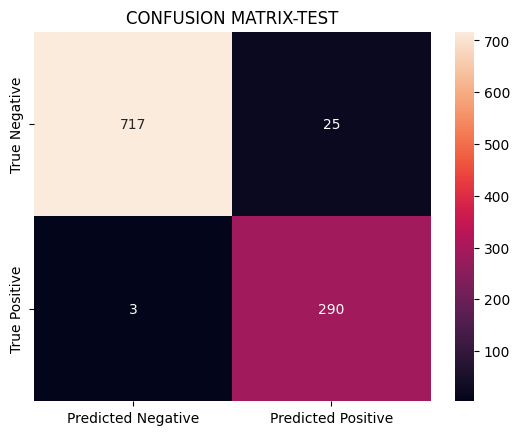

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       742
           1       0.92      0.99      0.95       293

    accuracy                           0.97      1035
   macro avg       0.96      0.98      0.97      1035
weighted avg       0.97      0.97      0.97      1035



In [ ]:
# loading trained model for evaluation
model_path = "/content/drive/MyDrive/NLP/bert/results/checkpoint-552"
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# model in evaluating mode
model.eval()

# loading test data for complete evaluation
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# empty lists for predictions and true labels
y_preds = []
y_labels = []
with torch.no_grad(): # disabling gradient compute in evaluating mode
    for batch in test_loader: # loop over test batches
        input_ids = batch['input_ids'] # batch words ids
        attention_mask = batch['attention_mask'] # attention mask
        labels = batch['label'] # true labels

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits # model logits (label scores)
        preds = torch.argmax(logits, dim=-1) # predicting the highest score label

        y_preds.extend(preds.cpu().tolist())
        y_labels.extend(labels.cpu().tolist())

print("Predictions:", y_preds)
print("True labels:", y_labels)

#confusion matrix
confusion(y_labels, y_preds, 'TEST')
#classification report
print(classification_report(y_labels, y_preds))


Come si nota, il modello TinyBert ha performance elevate, seppur lievemente inferiori al NB precedente. Questo è presumibilmente dovuto al numero di epoche utilizzate per l'addestramento e al fatto che questo sia stato svolto in modo semplificato. Risulta comunque una ottima scelta per questo task.

#**LDA**

In questa sezione si procede con la ricerca dei topics più frequenti nelle mail spam. Per questo si utilizza il Latent Dirichlet Allocation (LDA), un modello probabilistico generativo che si basa sull'assunzione che ogni mail sia una combinazione di vari topic, ognuno dei quali ha associate parole specifiche, sempre in senso probabilistico. LDA cerca quindi di trovare la distribuzione dei topics che meglio giustifica le parole presenti nelle mail.

Per applicare LDA alle mail, si considera il dataset pulito con l'apposita funzione definita all'inizio, filtrando solo le mail spam. La pulizia può sembrare svantaggiosa per ricononscere topics, in realtà consente di ridurre il vocabolario e di rendere i topics più chiari e individuabili al modello stesso. Inoltre l'algoritmo viene fatto lavorare su n iterazioni, necessarie per stabilizzare le predizioni dei topics.

Per LDA è necessario definire a priori quanti topics cercare. Trattandosi di una scelta arbitraria, si ottimizza tale valore ricercando il valore migliore su un insieme di 5, 10 e 15 topics. Per estrarre quello più adatto ai dati, si stima la coerenza, cioè una misura di quanto le parole associate ad un dato topic siano legate allo stesso contesto e semanticamente simili. Il numero di topics che produrrà il valore più elevato di coerenza, sarà da preferire.

Infine, si visualizza anche graficamente la distribuzione dei topics trovati. Il grafico è interattivo e consente di selezionare uno tra i topics, filtrando così le parole e mostrando quelle che più lo caratterizzano. Questa visualizzazione sarà anche utile ad associare ad ogni topic un significato esplicito.

In [ ]:
# filtering only spam dataset
df_spam=df_cleaned[df_cleaned['label_num']==1]
cleaned_texts=df_spam['text']
df_spam.head()

,text,label_num
3,subject photoshop window office cheap main tre...,1
7,subject look medication good source difficult ...,1
10,subject vocable rnd word asceticism vcsc brand...,1
11,subject report wffur attion brom est inst siup...,1
13,subject vic odin n ow berne hotbox carnal brid...,1


In [ ]:
# applying data cleaning function
print('- Tokenization')
tokenized_texts = [doc.split() for doc in cleaned_texts]

# creating vocabulary, excluding common and rare words
id2word=corpora.Dictionary(tokenized_texts)
id2word.filter_extremes(no_below=10, no_above=0.8)
# BoW representation
corpus=[id2word.doc2bow(text) for text in tokenized_texts]

# LDA application: the right number of topics is chosen using a loop over k (n. of topics),
# selecting the best k value using coherence estimation
print('- Coherence estimation')
coherence_scores = []
for k in [5, 10, 15]:
    lda = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, passes=10) # 10 iterations
    # coherence score to evaluate lda versions, in terms of topic interpretability and semantic meaning
    cm = CoherenceModel(model=lda, texts=tokenized_texts, dictionary=id2word, coherence='c_v')
    coherence = cm.get_coherence()
    coherence_scores.append((k, coherence))
    print(f"Num Topics={k}: Coherence={coherence:.4f}")
# best number of topics k
best_k = max(coherence_scores, key=lambda x: x[1])[0]
print(f"Best number of topics: {best_k}")

print('- Final LDA ')
# LDA fitting, using the best k (yielding the higher coherence) and 20 iterations
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=best_k, passes=20)

# word-topic visualization
lda_display = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.enable_notebook()
display(lda_display)


- Tokenization
- Coherence estimation
Num Topics=5: Coherence=0.6617
Num Topics=10: Coherence=0.6472
Num Topics=15: Coherence=0.5665
Best number of topics: 5
- Final LDA 


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.219010 -0.026567       1        1  30.822806
4      0.040981 -0.023480       2        1  28.553660
3     -0.209408 -0.159406       3        1  19.973121
2     -0.113668  0.225249       4        1  12.682095
0      0.063085 -0.015796       5        1   7.968318, topic_info=         Term         Freq        Total Category  logprob  loglift
9           I  1654.000000  1654.000000  Default  30.0000  30.0000
109   company   913.000000   913.000000  Default  29.0000  29.0000
27       http   951.000000   951.000000  Default  28.0000  28.0000
1614     font   494.000000   494.000000  Default  27.0000  27.0000
1608       td   484.000000   484.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
308       use    55.481046   377.265155   Topic5  -5.0749   0.6128
293    system    49.648700   199.469678   Topic5  -5.1860   1.1390
33        low    47.966790   215.058928   Topic5  -5.2204   1.0293
763     title    42.442460   104.863638   Topic5  -5.3428   1.6252
38       need    43.188790   343.204618   Topic5  -5.3254   0.4570

[367 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
9         1  0.011485          I
9         2  0.770699          I
9         3  0.051380          I
9         4  0.146282          I
9         5  0.019948          I
...     ...       ...        ...
777       5  0.041444          x
1101      3  0.981703      xanax
813       4  0.031098         xp
813       5  0.964024         xp
779       4  0.982932  zonedubai

[841 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

#**Topic ottenuti**
Il grafico precedente mostra come sono distribuiti i topics dedotti da LDA su uno spazio ridotto di 2 dimensioni. La distanza tra essi indica quanto siano simili, mentre la dimensione dei cerchi indica quanto è ricorrente quel topic.
Osservando il grafico si associa ad ogni gruppo trovato un topic esplicito, basato sulla presenza di alcune parole chiave nel gruppo stesso. Le categorie associate, si posso visualizzare nel seguente dizionario.

In [ ]:
# explicit topic definition
topic_dict={1:'Business',
            2:'Web site',
            3:'Pharma',
            4:'Selling',
            5:'Software'}

Nell'associare nomi espliciti ai topics si nota come in diversi topics vi siano parole associate alla vendita e/o al denaro, sintomo che su questi temi i cittadini sono più sensibili e intenti a cascare nella truffa.

#**Distanza semantica topics**
Una volta estratti i topics più importanti nelle mail spam, si passa a stimare la distanza semnatica tra essi, così da capire quanto siano diversi o no tra loro. Per fare questo, si costruisce per ogni topic un vettore lungo quanto il vocabolario usato per LDA, dove i valori del vettore rappresentano i pesi associati a ciascuna parola del vocabolario considerando il dato topic. Una volta ottenuto un vettore per ogni topic, si calcola la distanza tra essi usando la 'cosine similarity' che stima la sovrapposizione tra i vettori in modo indipendente dal modulo dei vettori stessi.

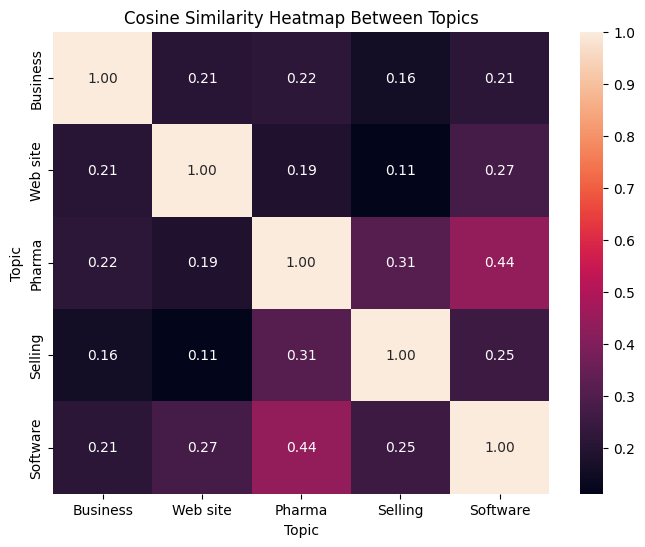

In [ ]:
# number of topics found with lda
num_topics = lda_model.num_topics
vocab_size = len(id2word)

# topic-word_weights matrix: num_topics x vocab_size
topic_word_vectors = np.zeros((num_topics, vocab_size))

# building the topic-word_weights matrix according to the weight of each word to each topic
for topic_id in range(num_topics):
    # for every topic a list of associated terms is returned, ordered by the probability of association with the topic
    topic_terms = lda_model.get_topic_terms(topicid=topic_id, topn=vocab_size)
    for word_id, weight in topic_terms:
        topic_word_vectors[topic_id, word_id] = weight

# cosine similarity matrix between topics
similarity_matrix = cosine_similarity(topic_word_vectors)

# similarity matrix plotting
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f",
            xticklabels=[topic_dict[i+1] for i in range(num_topics)],
            yticklabels=[topic_dict[i+1] for i in range(num_topics)])
plt.title("Cosine Similarity Heatmap Between Topics")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()


Si nota come i topics siano tra essi relativamente diversi, come testimoniato dalla distanza semantica. Questo valida l'analisi svolta da LDA, che ha saputo rintracciare categorie ben distinte. C'è però una puntualizzazione da fare: nel grafico precedente, si notava come alcuni topic fossero più vicini, mentre ora la distanza semantica risulta relativamente alta. Questo può essere legato al fatto che il grafico precedente applica in automatico una proiezione dei topics in uno spazio 2D adatto alla visualizzazione e questo potrebbe far apparire diverse le vere distanze. In generale la stima della 'cosine similarity' è certamete più completa e attendibile.

I topics più simili tendono ad essere quelli dove sono presenti spesso parole legate alla vendita e al denaro, come anticipato prima.

#**NER per riconoscimento organizzazioni**

Come ultimo passo, si procede ad applicare la Name Entity Recognition (NER) alle mail non spam, con l'obiettivo di individuare le organizzazioni/enti citati. Per questo task, si utilizza il modello linguistico preaddestrato per l'inglese 'en_core_web_sm' di Spacy allenato su grandi corpi testuali, passando il dataset non pulito tramite la funzione apposita, come invece fatto nelle sezioni precedenti: la pulizia infatti può compromettere la NER, limitando l'abilità di rilevare correttamente i nomi di enti presenti, ad esempio a causa della lemmatizzazione.

Alle mail si applica quindi il modello preaddestrato che in autonomia ricerca la presenza di enti. Alla fine del processo, viene restuito l'elenco senza doppioni degli enti rintracciati.

In [ ]:
# filtering nospam mails
df_nospam=df[df['label_num']==0]
sentences_nospam=df_nospam['text']

In [ ]:
# applying the pretrained nlp model to perform NER
processed_sent = [utils_dict['nlp'](sentence) for sentence in sentences_nospam]

# finding organizations in sentences
organizations=[] # list of lists
# loop over sentences
for sentence in processed_sent:
    organizations_found = [ent.text for ent in sentence.ents if ent.label_ == "ORG"]
    organizations.append(organizations_found)

# flattening organizations list of lists
flat_organizations = [org for sublist in organizations for org in sublist]

# creating set of organizations found
organizations_set = set(flat_organizations)

print(f"N. of ORG found: {len(organizations_set)}\n")
for item in organizations_set:
  print(item)

N. of ORG found: 1140

connie sutton / hou
army
angie
zeman / corp / enron @ enron
walter oil & gas
union gas corp .
p & l
luong / hou
blockbuster inc .
corbally / corp / enron @
devers @ columbia
snowy independence bowl
angie zeman / corp / enron @ enron
dell desktop computer
transportadora de gas del sur s
fox @ us .
black / corp / enron @
ami chokshi / corp / enron @ enron
cc : beverly beaty / hou
new york stock exchange
pennzoil
mobil beaumont
rockwell
camden resources inc .
tesoro hoskins central point
gpg
energy , inc .
peden / hou / ees @ ees
pg & e and
canfibre group ltd .
d & h '
meredith mitchell
energy corp .
boeing
apache corp
maffett / hou
bruce mills / corp / enron @ enron
searobin p / l
ftp
0 /
pamela chambers / corp / enron @ enron
subject :
paul devries / tor
mondragon
ocean energy inc .
u .
wagner & brown , ltd .
farley
burke
sullivan / hou / ect @ ect
deere
mack / corp / enron @ enron
christiansen / hou
sutton / hou
enron capital & trade resources corp .
pg & e @
pg 

Si nota come la NER rintracci efficacemente nomi di organizzazioni e enti. La mancata pulizia del dato testuale risulta essere una scelta giusta per la NER, ma al prezzo di parole poco ordinate e a volte ricche di punteggiatura non usuale in nomi di enti. In tal senso, forse una pulizia parziale, ad esempio eliminando solo quella punteggiatura che di sicuro non compare in nomi di organizzazioni, potrebbe rendere ancora più chiara la visualizzazione finale e rendere più corretta la lista delle organizzazioni trovate.

#**Riferimenti**
- nlpaug: https://nlpaug.readthedocs.io/en/latest/
- TinyBert: https://huggingface.co/prajjwal1/bert-tiny
- LDA: https://www.ibm.com/it-it/think/topics/latent-dirichlet-allocation
- NER: https://www.ibm.com/it-it/think/topics/named-entity-recognition